In [1]:
!pip install umap-learn biopython transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

### **Data Preprocessing**:
*   Download sequences in FASTA format
*   Filter to get 200-500 sequences with binary labels (e.g., resistant vs. non-resistant)
*   Clean sequences (remove ambiguous nucleotides, standardize length if necessary)
*   Split data into classes based on labels

In [13]:
def normalize_id(id_str):
    if '.' in id_str:
        left, right = id_str.split('.')
        return f"{left}.{right.ljust(5, '0')}"
    return id_str

In [41]:
from Bio import SeqIO
import pandas as pd
import numpy as np


# Step 1: Parse FASTA file and collect sequences with their IDs
fasta_records = []
for record in SeqIO.parse("pbp4.fasta", "fasta"):
    fasta_records.append({
        'id': record.id,  # Extracts the unique ID like 1280.113
        'sequence': str(record.seq)
    })

fasta_df = pd.DataFrame(fasta_records)

fasta_df['id'] = fasta_df['id'].astype(str).apply(normalize_id)

print("Shape of fasta_df: ", fasta_df.shape)

# Step 2: Load labels file (Two columns: id and label)
labels_df = pd.read_csv("labels.txt", sep='\t', engine='python', header=None, names=['id', 'label'])
labels_df['id'] = labels_df['id'].astype(str).apply(normalize_id)

print("Shape of labels_df: ", labels_df.shape)

# # --- Added for debugging ---
# print("First 5 IDs in fasta_df:")
# print(fasta_df['id'].head())
# print("\nFirst 5 IDs in labels_df:")
# print(labels_df['id'].head())
# print("-" * 20)
# # --- End of debugging additions ---

# Step 3: Merge the sequences with labels on ID
merged_df = pd.merge(fasta_df, labels_df, on='id')

# --- Added for debugging ---
print(f"Number of rows in merged_df after initial merge: {len(merged_df)}")
# --- End of debugging additions ---

# print("Shape after merging: ", merged_df.shape)

# Step 4: Remove sequences with ambiguous nucleotides
merged_df['sequence'] = merged_df['sequence'].str.upper()
merged_df = merged_df[~merged_df['sequence'].str.contains('[^ATGC]')]

# print("Shape after merging: ", merged_df.shape)

merged_df.to_csv('processed_sequences.csv', index=False)

# # Step 5: Balance the classes if needed
# min_class_size = min(merged_df['label'].value_counts())
# data_bal = pd.concat([
#     merged_df[merged_df['label'] == 0].sample(min_class_size, random_state=42),
#     merged_df[merged_df['label'] == 1].sample(min_class_size, random_state=42)
# ])

# # Step 6: Save processed data
# data_bal.to_csv('processed_sequences.csv', index=False)

Shape of fasta_df:  (135, 2)
Shape of labels_df:  (135, 2)
Number of rows in merged_df after initial merge: 135


In [43]:
data_bal.shape
min_class_size = min(data_bal['label'].value_counts())
data_bal['label'].value_counts()

merged_df.shape
min_class_size = min(merged_df['label'].value_counts())
merged_df['label'].value_counts()

,count
label,
1,98
0,37


### **Generate DNABERT Embeddings**

In [44]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import pandas as pd

# Load tokenizer and model
model_name = "zhihan1996/DNA_bert_6"  # For 6-mer DNABERT
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Function to convert DNA sequence to k-mers
def seq_to_kmers(seq, k=6):
    kmers = []
    for i in range(len(seq) - k + 1):
        kmers.append(seq[i:i+k])
    return " ".join(kmers)

# Load your sequences
data = pd.read_csv('processed_sequences.csv')

# Convert to k-mers and generate embeddings
embeddings = []
labels = []

for idx, row in data.iterrows():
    seq = row['sequence']
    label = row['label']

    # Convert to k-mers
    kmer_seq = seq_to_kmers(seq)

    # Tokenize and get embeddings
    inputs = tokenizer(kmer_seq, return_tensors="pt", truncation=True, max_length=512)

    with torch.no_grad():
        outputs = model(**inputs)

    # Get CLS token embedding (first token)
    cls_embedding = outputs.last_hidden_state[:, 0, :].numpy().flatten()

    embeddings.append(cls_embedding)
    labels.append(label)

# Save embeddings
embedding_df = pd.DataFrame(embeddings)
embedding_df['label'] = labels
embedding_df.to_csv('dnabert_embeddings.csv', index=False)

### **Dimensionality Reduction and Visualization**

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


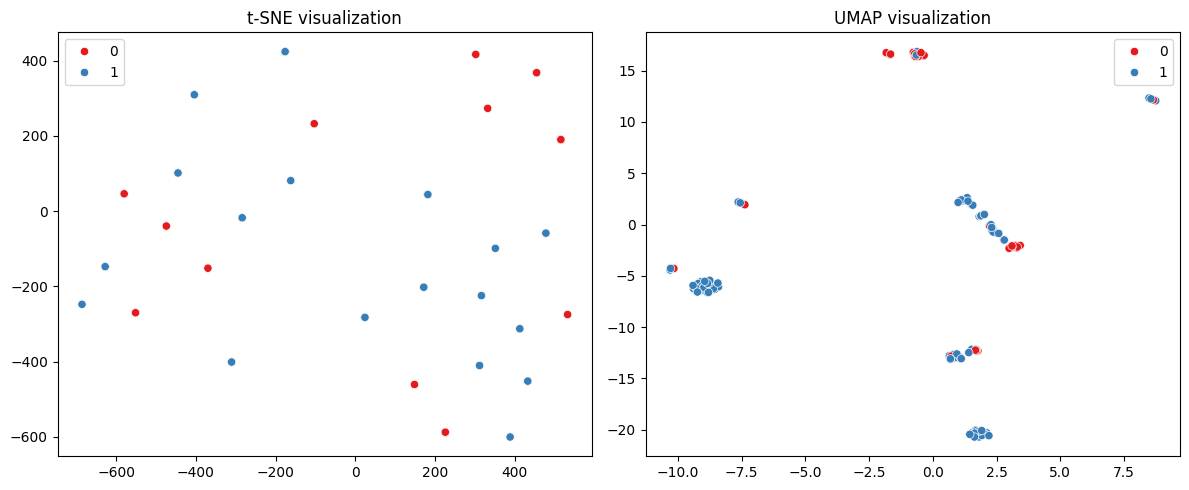

In [45]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Load embeddings
embedding_df = pd.read_csv('dnabert_embeddings.csv')
X = embedding_df.drop('label', axis=1).values
y = embedding_df['label'].values

# PCA for initial dimensionality reduction
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame(X_pca)
pca_df.columns = [f'PC{i+1}' for i in range(pca_df.shape[1])]
pca_df.to_csv('pca_embeddings.csv', index=False)

# t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# UMAP for visualization (alternative)
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_pca)

umap_df = pd.DataFrame(X_umap)
# umap_df.columns = [f'PC{i+1}' for i in range(pca_df.shape[1])]
umap_df.to_csv('umap_embeddings.csv', index=False)

# Visualize
plt.figure(figsize=(12, 5))

# t-SNE plot
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='Set1')
plt.title('t-SNE visualization')

# UMAP plot
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette='Set1')
plt.title('UMAP visualization')

plt.tight_layout()
plt.savefig('embedding_visualization.png')
plt.show()

### **Outlier Detection**

/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


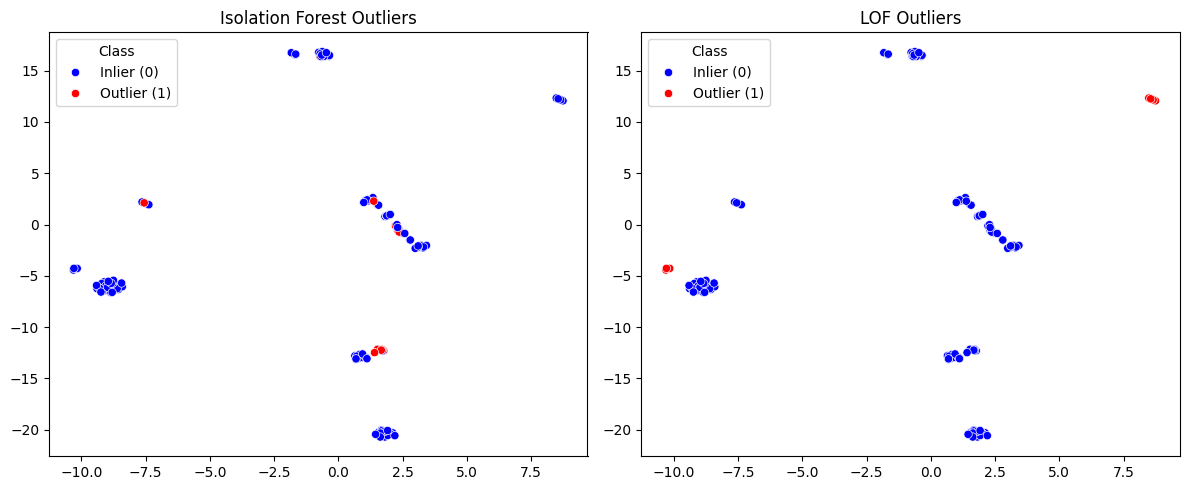

In [57]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
import matplotlib.pyplot as plt

# Load dimensionality-reduced embeddings
X_pca = pd.read_csv('pca_embeddings.csv').values
labels = pd.read_csv('dnabert_embeddings.csv')['label'].values

# Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.10, random_state=42)
outliers_if = iso_forest.fit_predict(X_pca)
# Convert to binary (1: inlier, -1: outlier)
outliers_if = [1 if x == -1 else 0 for x in outliers_if]

# Apply Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.10)
outliers_lof = lof.fit_predict(X_pca)
# Convert to binary (1: inlier, -1: outlier)
outliers_lof = [1 if x == -1 else 0 for x in outliers_lof]

# Create DataFrame with results
results = pd.DataFrame({
    'sequence_id': range(len(X_pca)),
    'true_label': labels,
    'isolation_forest_outlier': outliers_if,
    'lof_outlier': outliers_lof,
    'consensus_outlier': [1 if a + b > 0 else 0 for a, b in zip(outliers_if, outliers_lof)]
})

# Save results
results.to_csv('outlier_detection_results.csv', index=False)

# Visualize outliers on UMAP projection
X_umap = pd.read_csv('umap_embeddings.csv').values

plt.figure(figsize=(12, 5))

# Plot by Isolation Forest
plt.subplot(1, 2, 1)
scatter_iso = sns.scatterplot(
    x=X_umap[:, 0],
    y=X_umap[:, 1],
    hue=outliers_if,
    palette={0: 'blue', 1: 'red'}
)
plt.title('Isolation Forest Outliers')
handles, _ = scatter_iso.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Inlier (0)', 'Outlier (1)'], title='Class')


# Plot by LOF
plt.subplot(1, 2, 2)
scatter_lof = sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=outliers_lof, palette={0: 'blue', 1: 'red'})
plt.title('LOF Outliers')
handles, _ = scatter_lof.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Inlier (0)', 'Outlier (1)'], title='Class')


plt.tight_layout()
plt.savefig('outlier_visualization.png')
plt.show()

### **Evaluation and Analysis**

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from Bio import Entrez, SeqIO
from io import StringIO

# Load data
results = pd.read_csv('outlier_detection_results.csv')
X_pca = pd.read_csv('pca_embeddings.csv').values
labels = results['true_label'].values
outliers = results['consensus_outlier'].values

# Evaluate impact on classification
# Create datasets with and without outliers
X_with_outliers = X_pca
y_with_outliers = labels

X_without_outliers = X_pca[outliers == 0]
y_without_outliers = labels[outliers == 0]

# Train-test split
X_train_with, X_test_with, y_train_with, y_test_with = train_test_split(
    X_with_outliers, y_with_outliers, test_size=0.3, random_state=42)

X_train_without, X_test_without, y_train_without, y_test_without = train_test_split(
    X_without_outliers, y_without_outliers, test_size=0.3, random_state=42)

# Train classifiers
clf_with = LogisticRegression(random_state=42).fit(X_train_with, y_train_with)
clf_without = LogisticRegression(random_state=42).fit(X_train_without, y_train_without)

# Evaluate
y_pred_with = clf_with.predict(X_test_with)
y_pred_without = clf_without.predict(X_test_without)

# Print results
print("Classification with outliers:")
print(classification_report(y_test_with, y_pred_with))
print("Accuracy:", accuracy_score(y_test_with, y_pred_with))

print("\nClassification without outliers:")
print(classification_report(y_test_without, y_pred_without))
print("Accuracy:", accuracy_score(y_test_without, y_pred_without))

# Optional: BLAST validation for a few outliers
# This is a simplified example - would need to be expanded
def blast_sequence(seq):
    Entrez.email = "your_email@example.com"  # Set your email

    # Run BLAST
    result_handle = NCBI.qblast("blastn", "nt", seq)
    blast_results = result_handle.read()
    return blast_results

# Analyze a few outliers if original sequences are available
original_sequences = pd.read_csv('processed_sequences.csv')['sequence'].values
outlier_indices = np.where(outliers == 1)[0]

for idx in outlier_indices[:5]:  # First 5 outliers
    seq = original_sequences[idx]
    true_label = labels[idx]
    print(f"Outlier {idx}, True label: {true_label}")
    print(f"Sequence length: {len(seq)}")
    # Uncomment to run BLAST (takes time)
    # blast_result = blast_sequence(seq)
    # print("BLAST top hit:", blast_result)
    print("-" * 50)

Classification with outliers:
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        11
           1       0.94      0.97      0.95        30

    accuracy                           0.93        41
   macro avg       0.92      0.89      0.90        41
weighted avg       0.93      0.93      0.93        41

Accuracy: 0.926829268292683

Classification without outliers:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.95      0.91      0.93        23

    accuracy                           0.91        33
   macro avg       0.89      0.91      0.90        33
weighted avg       0.91      0.91      0.91        33

Accuracy: 0.9090909090909091
Outlier 1, True label: 0
Sequence length: 1296
--------------------------------------------------
Outlier 5, True label: 0
Sequence length: 1296
--------------------------------------------------
Outlier 7, True label: 1
Sequ